# Caso Libre: Restaurantes con Estrella Michelin

En este segundo ejercicio, voy a estudiar un dataset de restaurantes que poseen una estrella michelín. Además, para completar los datos he decidido juntarlos con datos de calidad de vida por país, realizando un Web Scraping de la página *numbeo.com*. Al final, quiero ver cómo depende el precio y el número de estrellas del restaurante de el resto de variables.

**COMENTARIO**: En un principio he querido juntar datos de calidad de vida para cada ciudad, sin embargo, debido a falta de tiempo y complicaciones a la hora de encontrar uniones entre tablas he decidido conformarme con datos de país.

## Creación de los Datasets y Limpieza

Primero cargamos las librerías necesarias y los datos de restaurantes.

In [1]:
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
import requests

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from plotnine import *
from matplotlib import gridspec
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
one_star = pd.read_csv("datos/one-star-michelin-restaurants.csv")
two_star = pd.read_csv("datos/two-stars-michelin-restaurants.csv")
three_star = pd.read_csv("datos/three-stars-michelin-restaurants.csv")

one_star["Michelin Stars"] = 1
two_star["Michelin Stars"] = 2
three_star["Michelin Stars"] = 3

Hemos creado una columna nueva que indique el número de estrellas para cada restaurante. A continuación se unen los tres dataframes y se eliminan columnas innecesarias como la url del resturante o el código postal.

In [3]:
michelin = pd.concat([one_star, two_star, three_star], axis=0).drop(columns=["url", "zipCode"])

In [4]:
michelin.head()

,name,year,latitude,longitude,city,region,cuisine,price,Michelin Stars
0,Kilian Stuba,2019,47.348580,10.17114,Kleinwalsertal,Austria,Creative,$$$$$,1
1,Pfefferschiff,2019,47.837870,13.07917,Hallwang,Austria,Classic cuisine,$$$$$,1
2,Esszimmer,2019,47.806850,13.03409,Salzburg,Austria,Creative,$$$$$,1
3,Carpe Diem,2019,47.800010,13.04006,Salzburg,Austria,Market cuisine,$$$$$,1
4,Edvard,2019,48.216503,16.36852,Wien,Austria,Modern cuisine,$$$$,1


In [5]:
print("El dataset tiene {} filas y {} columnas.".format(michelin.shape[0], michelin.shape[1]))

El dataset tiene 695 filas y 9 columnas.


Vemos que los datos se han cargado bien, pero la columna del precio, tiene un formato poco apto para el análisis. Se van a transformar los símbolos de dólar en números (de 1 a 5). Quiero recalcar que aunque parece que el restaurante *Kilian Stuba* tiene un precio de 1 dólar, en realidad tiene 5. Estos errores de visualización nos dan la razón para pasar a numérico.

In [6]:
michelin.price = michelin.price.apply(lambda x: len(x) if type(x) is str  else np.nan)

A continuación vamos a tratar los nulos:

In [7]:
michelin.isna().sum()

name                0
year                0
latitude            0
longitude           0
city                2
region              0
cuisine             0
price             176
Michelin Stars      0
dtype: int64

Lo primero va a ser rellenar los nulos en la variable ciudad, vemos que ambos pertenecen a Hong Kong:

In [8]:
michelin[michelin.city.isna()]

,name,year,latitude,longitude,city,region,cuisine,price,Michelin Stars
152,Épure,2019,22.295830,114.169304,NaN,Hong Kong,French,3.0,1
166,Arbor,2019,22.283146,114.155420,NaN,Hong Kong,Innovative,3.0,1


In [9]:
michelin.city = michelin.city.fillna("Hong Kong")

Vemos que hay muchos nulos también en precio. Para arreglar este problema usamos un dataset de Kaggle que ya ha calculado los precios de los nulos usando Random Forest.

In [10]:
prices = pd.read_csv("datos/Missing_Price_Values_Predictions.csv")
prices.head()

,name,year,latitude,longitude,city,region,cuisine,price,Michelin Stars
0,Aniar,2019,53.271120,-9.057078,2,14,46,5.0,1
1,Loam,2019,53.273840,-9.044447,2,14,46,5.0,1
2,Wild Honey Inn,2019,53.031510,-9.291100,1,14,15,5.0,1
3,Chestnut,2019,51.562588,-9.460854,1,14,108,5.0,1
4,Mews,2019,51.482850,-9.372340,1,14,108,5.0,1


Y se sustituyen sus valores de precio en los nulos de nuestro dataset *Michelin*.

In [11]:
michelin = michelin.set_index("name").combine_first(prices.set_index("name")).reset_index()

Ya tenemos el datset de Michelin completamente limpio y con los datos correctos. Es la hora de juntarlo con los índices de calidad de vida por país. Primero el scrapeo:

In [12]:
# abrir el archivo html
response = requests.get("https://www.numbeo.com/quality-of-life/rankings_by_country.jsp")
soup = BeautifulSoup(response.text, "html.parser")
    
# guardamos tabla
table_q = soup.find('table', class_='stripe row-border order-column compact')
    
# guardamos nombres de columnas
columns = table_q.find('tr')
col_names = [th.text.strip() for th in columns.findAll('th')[1:]]
    
# rellemanos las filas
rows = []
body = table_q.find('tbody')
for row in body.findAll('tr'):
    rows.append([td.text.strip() for td in row.findAll('td')[1:]])

#hacer el dataframe
quality = pd.DataFrame(rows)
quality.columns = col_names

In [13]:
quality.head()

,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
0,Switzerland,190.82,110.96,78.65,74.47,131.75,8.42,28.73,20.09,80.05
1,Denmark,190.01,94.73,73.28,79.96,91.67,6.66,28.69,20.40,81.80
2,Netherlands,183.31,83.89,72.78,75.76,78.64,7.35,27.81,25.28,87.11
3,Finland,182.79,89.05,72.99,76.40,77.46,8.64,28.96,11.86,56.64
4,Austria,182.37,78.23,74.77,78.40,75.49,10.40,25.68,19.20,77.79


Y los unimos por país.

In [14]:
michelin_q = michelin.merge(quality, how="left", left_on="region", right_on="Country")
michelin_q

,name,year,latitude,longitude,city,region,cuisine,price,Michelin Stars,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
0,108,2019,55.677850,12.598084,København,Denmark,Modern cuisine,3.0,1,Denmark,190.01,94.73,73.28,79.96,91.67,6.66,28.69,20.40,81.80
1,21212,2019,55.956740,-3.180180,Edinburgh,United Kingdom,Creative,4.0,1,United Kingdom,158.99,82.56,54.74,74.93,71.03,9.57,34.44,40.25,88.04
2,28+,2019,57.698090,11.973770,Göteborg,Sweden,Modern cuisine,3.0,1,Sweden,171.40,90.55,52.80,68.80,79.17,8.56,29.89,18.44,74.92
3,360º,2019,42.641563,18.111523,Dubrovnik,Croatia,Modern cuisine,5.0,1,Croatia,156.10,43.13,75.09,64.23,56.36,14.20,28.13,30.58,89.69
4,8 1/2 Otto e Mezzo - Bombana,2019,22.149180,113.553930,Macau,Macau,Italian,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
692,n/naka,2019,34.025260,-118.412060,Los Angeles,California,Contemporary,4.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
693,noma,2019,55.683320,12.610060,København,Denmark,Creative,4.0,2,Denmark,190.01,94.73,73.28,79.96,91.67,6.66,28.69,20.40,81.80
694,wilks,2019,51.467370,-2.606990,Bristol,United Kingdom,Modern British,4.0,1,United Kingdom,158.99,82.56,54.74,74.93,71.03,9.57,34.44,40.25,88.04
695,Écriture,2019,22.283150,114.155400,Hong Kong,Hong Kong,French contemporary,3.0,2,Hong Kong,99.34,62.45,78.27,66.34,79.94,45.19,42.28,67.30,83.64


Vemos que hay muchos que no se han unido bien. Vamos a ver cuáles son.

In [15]:
nas = michelin_q[michelin_q.isna().any(axis=1)]
nas

,name,year,latitude,longitude,city,region,cuisine,price,Michelin Stars,Country,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
4,8 1/2 Otto e Mezzo - Bombana,2019,22.149180,113.55393,Macau,Macau,Italian,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Acadia,2019,41.859040,-87.62562,Chicago,Chicago,Contemporary,4.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Acquerello,2019,37.791670,-122.42131,San Francisco,California,Italian,4.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Addison,2019,32.939903,-117.20013,San Diego,California,Contemporary,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Agern,2019,40.752340,-73.97750,New York,New York City,Scandinavian,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,Zi Yat Heen,2019,22.145418,113.56152,Macau,Macau,Cantonese,2.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
689,jū-ni,2019,37.776720,-122.43886,San Francisco,California,Japanese,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
690,logy,2019,25.035610,121.55323,Taipei,Taipei,Asian contemporary,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
691,minibar,2019,38.896294,-77.02386,"Washington, D.C.",Washington DC,Contemporary,4.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Me doy cuenta que las filas con NA's se deben a una razón, se tratan de ciudades aisladas:

- California, New York City, Washington DC y Chicago deberían pasar a United States
- Sao Paulo y Rio de Janeiro a Brasil
- Macau y Taipei. Al ser ciudades aisladas con unos índices superiores a los de su región, he decidido insertales los datos de Corea del Sur por parecido.

In [16]:
michelin["region"] = michelin["region"].replace(["California","New York City", "Washington DC", "Chicago"], "United States")
michelin["region"] = michelin["region"].replace(["Sao Paulo", "Rio de Janeiro"], "Brazil")
michelin["region"] = michelin["region"].replace(["Taipei", "Macau"], "South Korea")

Ahora podemos cruzar de nuevo los índices de calidad de vida  sin errores:

In [17]:
michelin = michelin.merge(quality, how="left", left_on="region", right_on="Country")

Por último podemos eliminar la variable *region*, ya que coincide con *Country*.

In [18]:
michelin = michelin.drop(columns="region")

## Estudio de las variables

Lo primero es tener una visión general del tipo de datos.

In [19]:
michelin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 697 entries, 0 to 696
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            697 non-null    object 
 1   year                            697 non-null    int64  
 2   latitude                        697 non-null    float64
 3   longitude                       697 non-null    float64
 4   city                            697 non-null    object 
 5   cuisine                         697 non-null    object 
 6   price                           697 non-null    float64
 7   Michelin Stars                  697 non-null    int64  
 8   Country                         697 non-null    object 
 9   Quality of Life Index           697 non-null    object 
 10  Purchasing Power Index          697 non-null    object 
 11  Safety Index                    697 non-null    object 
 12  Health Care Index               697 

Antes de pasar al estudio de cada variable, vamos a transformarlas a su tipo adecuado. Todas las variables de índice de calidad deberían ser numéricas, mientras que *Michelin Stars* debería ser objeto.

In [20]:
indices = ["Quality of Life Index","Purchasing Power Index","Safety Index","Health Care Index","Cost of Living Index",
           "Property Price to Income Ratio","Traffic Commute Time Index","Pollution Index","Climate Index"]

michelin.loc[:,indices] = michelin.loc[:,indices].astype(float)
michelin.loc[:,"Michelin Stars"] = michelin.loc[:,"Michelin Stars"].astype(str).astype(object)
michelin.loc[:,"price"] = michelin.loc[:,"price"].astype(str).astype(object)

A continuación vamos a estudiar por separado las distintas variables por su significado y cómo afectan al precio de los restaurantes. Se recopilarán todas las conclusiones al final.

### Variables geográficas

Vamos a ver cómo se distribuyen los restaurantes en el globo y por país.

<AxesSubplot:>

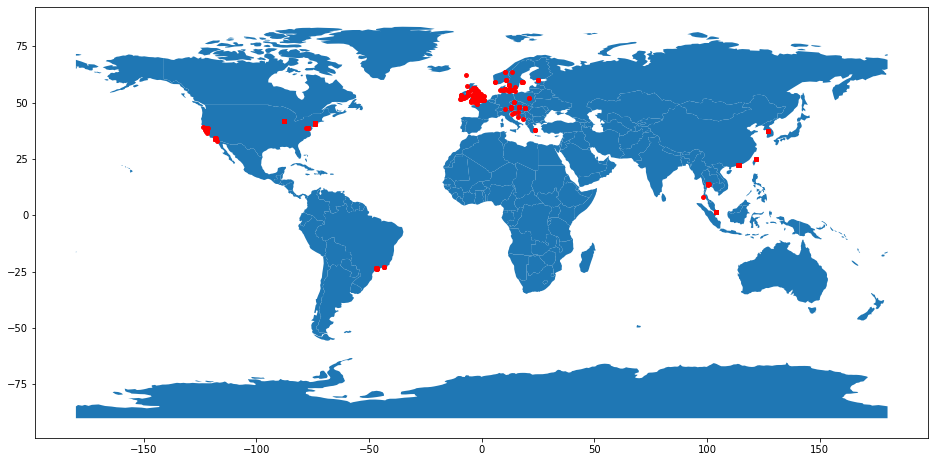

In [21]:
geometry = [Point(xy) for xy in zip(michelin['longitude'], michelin['latitude'])]
gdf = GeoDataFrame(michelin, geometry=geometry)   

# Mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(16, 9)), marker='o', color='red', markersize=15)

No aparecen restaurantes en Francia, España ni Japón, donde tradicionalmente se ecuentran la mayoría de restaurantes de más alta gama, pero tenemos que trabajar con los datos de los que disponemos.

Vemos que una gran parte de los restuaurantes se encuentran en las Islas Británicas y la costa oeste de EEUU. El resto se distribuyen en los países nórdicos, europa del este, resto de EEUU, Brasil y Asia. Vamos a ver aquellos países con más restaurantes.

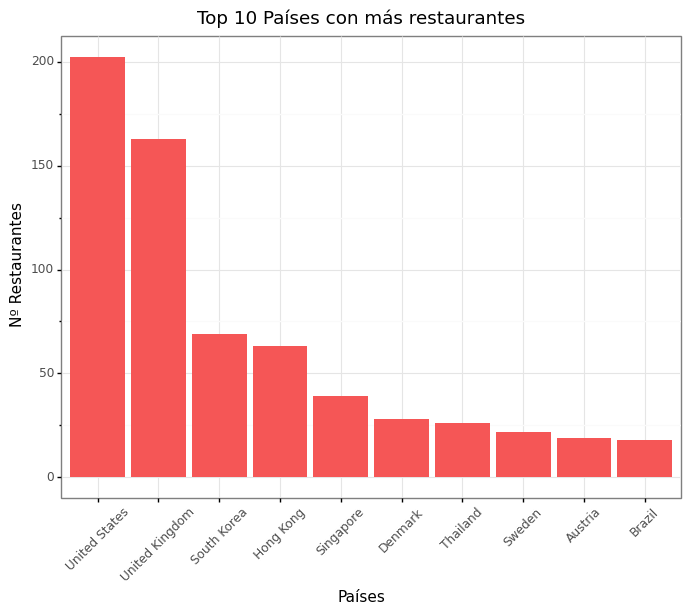

<ggplot: (-9223371886859781624)>

In [22]:
pais = michelin["Country"].value_counts().head(10)
ggplot(pd.DataFrame(pais)) +\
geom_bar(aes(x = pais.index.tolist(),y=pais.values.tolist()), 
             position = "dodge", stat = "identity", fill='#f55656') +\
scale_x_discrete(limits=pais.index.tolist()) +\
theme_bw() +\
labs(title="Top 10 Países con más restaurantes") +\
xlab("Países") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 45), figure_size=(8,6))

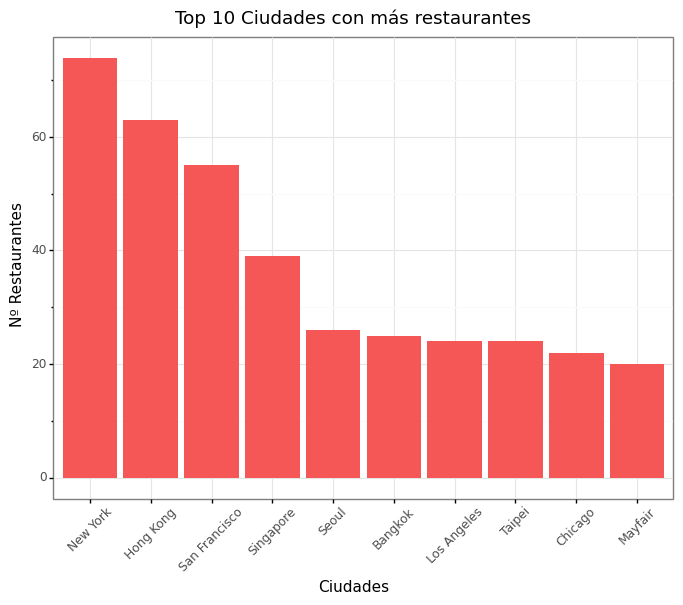

<ggplot: (-9223371886859484940)>

In [23]:
ciudad = michelin["city"].value_counts().head(10)
ggplot(pd.DataFrame(pais)) +\
geom_bar(aes(x = ciudad.index.tolist(),y=ciudad.values.tolist()), 
             position = "dodge", stat = "identity", fill='#f55656') +\
scale_x_discrete(limits=ciudad.index.tolist()) +\
theme_bw() +\
labs(title="Top 10 Ciudades con más restaurantes") +\
xlab("Ciudades") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 45), figure_size=(8,6))

Vemos que las ciudades y los países con mayor número de restaurantes se definen como del primer mundo o desarrollados, lo cual es lógico. Pasamos a ver cómo se distribuyen las estrellas por zona geográfica, tomando de nuevo el top 10.

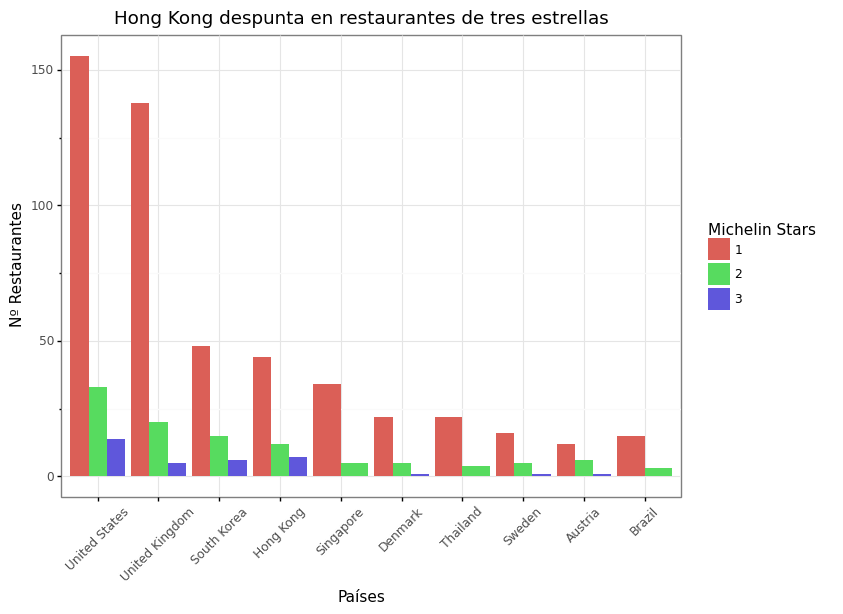

<ggplot: (-9223371886859814272)>

In [24]:
pais_star = michelin[["Country","Michelin Stars"]][michelin.Country.isin(pais.index.tolist())]
ggplot(pais_star) +\
geom_bar(aes(x = "Country",fill="Michelin Stars"), 
             position = "dodge") +\
scale_x_discrete(limits=pais.index.tolist()) +\
theme_bw() +\
labs(title="Hong Kong despunta en restaurantes de tres estrellas") +\
xlab("Países") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 45), figure_size=(8,6))

Vemos que para los restaurantes de 1 y 2 estrellas siguen una distribución parecida a los números totales. EEUU y UK son los que más restaurantes tienen por lo que es lógico que también tengan más números de 1 y 2 estrellas, igual que el resto excepto Austria que sube un poco el número de 2 estrellas. El caso de los restaurantes de 3 estrellas es algo distinto. Al ser la mayor puntuación es normal que el número sea menor. 

Sin embargo, este número no sigue la misma tendencia que los anteriores. EEUU tiene el máximo número de 3\*, pero UK tiene un número muy inferior. De hecho, los países siguientes (Corea del Sur no se cuenta por haberse sumado los tres restaurantes de 3\* de Macau y uno de Taipei), como Hong Kong, le superan en este campo. Esto podría tener que ver con el tipo de cocina, que se verá más adelante. Hay algunos países que no tienen restaurantes de 3\*.

Vamos a verlo por ciudades.

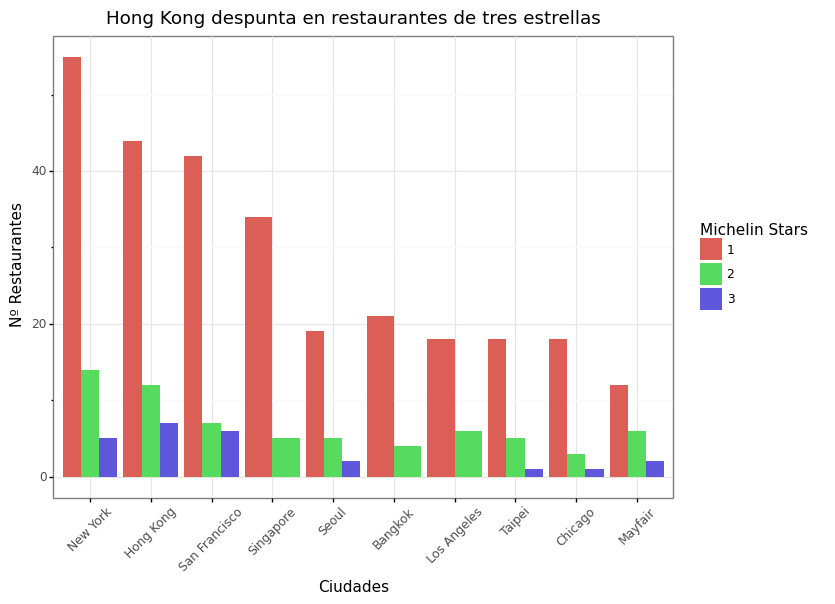

<ggplot: (-9223371886859650320)>

In [25]:
ciudad_star = michelin[["city","Michelin Stars"]][michelin.city.isin(ciudad.index.tolist())]
ggplot(ciudad_star) +\
geom_bar(aes(x = "city",fill="Michelin Stars"), 
             position = "dodge") +\
scale_x_discrete(limits=ciudad.index.tolist()) +\
theme_bw() +\
labs(title="Hong Kong despunta en restaurantes de tres estrellas") +\
xlab("Ciudades") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 45), figure_size=(8,6))

En primer lugar, como comentario, se ve que la distibución de restaurantes de 1\* es parecida a las anteriores, con un gran número en New York y otras ciudades asiáticas. El número va descendeiendo en el Top a un ritmo parecido al del nº de restaurantes total. El nº de restaurantes de 2\* tiene más fluctuaciones pero en general se parece al de 1\*.

Al contrario, los restaurantes de 3\* tienen una distribución distinta. New York no tiene el mayor número, sino que lo tiene Hong Kong. Hong Kong, al ser una ciudad y territorio autónomo, aparece como ciudad y como país. Su número es más alto que el resto porque no se reparte entre más ciudades. Sin embargo, esto no explica su elevado número de restaurantes de 3\*. Se comprobará si tiene que ver con el tipo de cocina, pero también se puede suponer que al ser un centro financiero global y de comercio, la calidad de sus restaurantes de alta gama será muy superior.

De nuevo, hay muchas ciudades sin restaurantes de 3\*, y al final del Top 10 vuelven a crecer en número. El caso de Mayfair es especial, ya que se trata de uno de los barrios más prestigiosos de Londres, pero se trata aquí como una ciudad en sí misma.

Vamos a realizar el mismo estudio para la gama de precios.

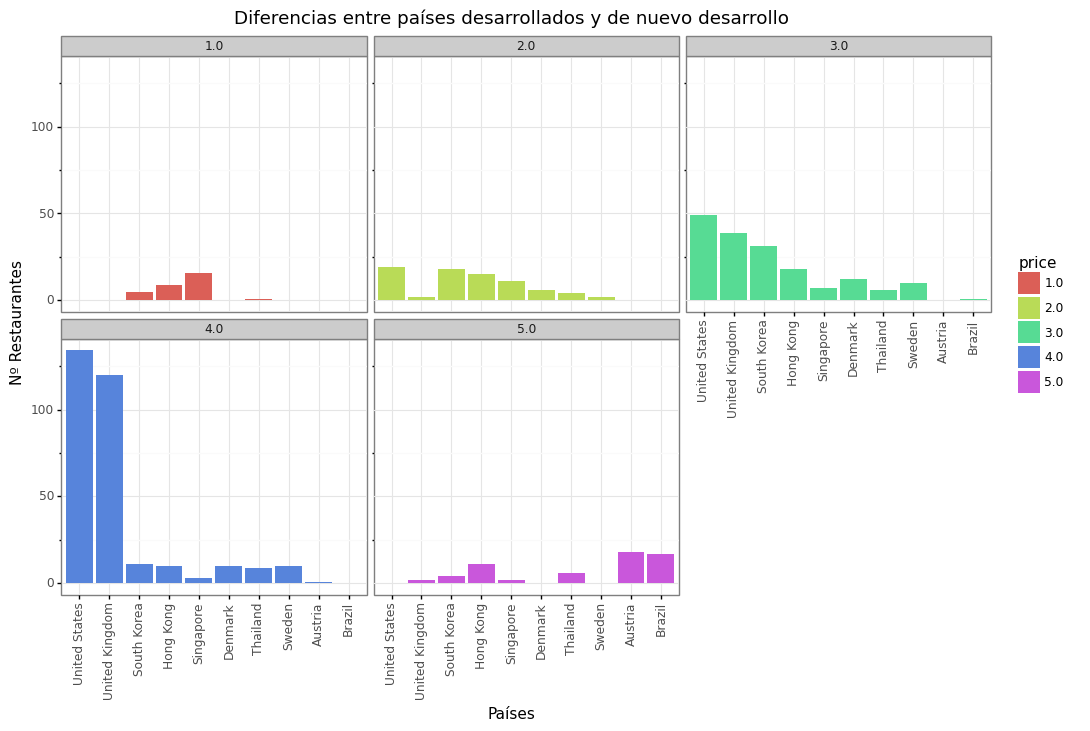

<ggplot: (-9223371886859459228)>

In [26]:
pais_price = michelin[["Country","price"]][michelin.Country.isin(pais.index.tolist())]
ggplot(pais_price) +\
geom_bar(aes(x = "Country",fill="price"), 
             position = "dodge") +\
scale_x_discrete(limits=pais.index.tolist()) +\
facet_wrap("price") +\
theme_bw() +\
labs(title="Diferencias entre países desarrollados y de nuevo desarrollo") +\
xlab("Países") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 90), figure_size=(12,7))

En primer lugar, vemos que los tramos de precios más comunes son los de 3 y 4. Los del tramo 3 tienen un número más parecido entre países, sin embargo, en los de 4 el ratio es mucho mayor en EEUU y UK. Estos países llevan siendo desarrollados mucho mas tiempo que la mayoría, por lo que los precios se han ido acomodando a un rango de la población más amplio. Esto se demuestra en los restaurantes de precio 5, prácticamente inexistentes en estos dos países. En este caso se da la mayoría en Austria, Brasil y Hong Kong. El caso de estos dos últimos es parecido, países/regiones con un desarrollo más actual, por lo que las diferencias económicas entre la población están más acentuadas. El caso de Austria podría deberse a otros factores de calidad o coste de vida.

Vemos lo mismo para ciudades.

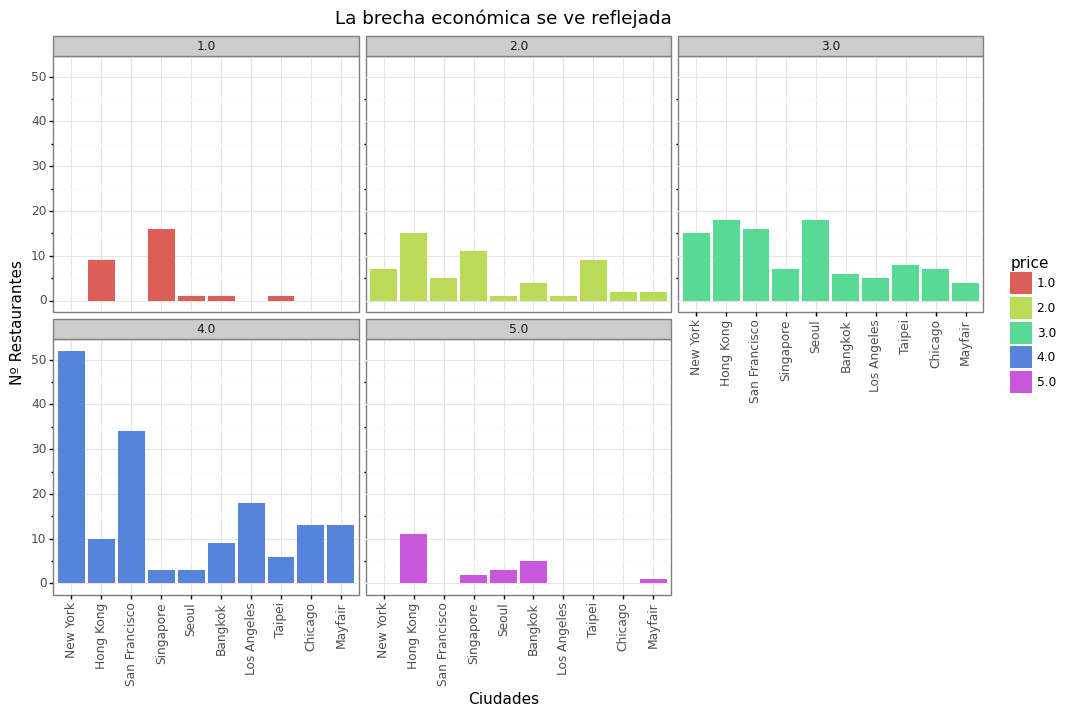

<ggplot: (-9223371886859645020)>

In [27]:
ciudad_price = michelin[["city","price"]][michelin.city.isin(ciudad.index.tolist())]
ggplot(ciudad_price) +\
geom_bar(aes(x = "city",fill="price"), 
             position = "dodge") +\
scale_x_discrete(limits=ciudad.index.tolist()) +\
facet_wrap("price") +\
theme_bw() +\
labs(title="La brecha económica se ve reflejada") +\
xlab("Ciudades") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 90), figure_size=(12,7))

Aquí vemos otro ejemplo de las diferencias entre países ya desarrollados y los de nuevo desarrollo. En el tramo de precio 3 los datos son relativamente uniformes, sin embargo, en el tramo 4 ya despuntan ciudades como New York, San Francisco, Los Angeles, Chicago y Mayfair. En el tramo 5 despuntan Hong Kong, Bangkok, Seoul y Singapore. Las diferencias económicas y sociales de los países asiáticos de nuevo desarrollo inducen a esta brecha de precios en el tramo 4, que se llena con ciudades de países ya desarrollados como EEUU y UK.

### Variables propias del restaurante: Tipo de cocina

Vamos a ver cómo influye el tipo de cocina en el resto de variables. Lo primero, ver la distribución.

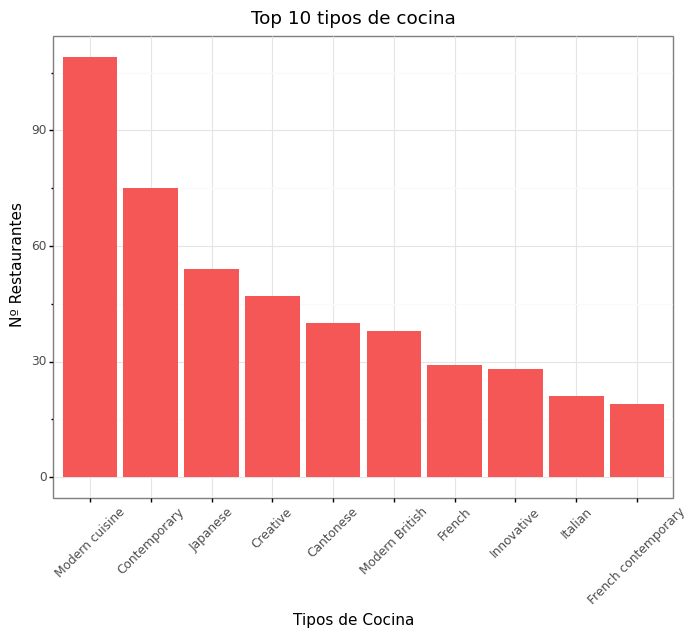

<ggplot: (-9223371886859268108)>

In [28]:
cocina = michelin["cuisine"].value_counts().head(10)
ggplot(pd.DataFrame(cocina)) +\
geom_bar(aes(x = cocina.index.tolist(),y=cocina.values.tolist()), 
             position = "dodge", stat = "identity", fill='#f55656') +\
scale_x_discrete(limits=cocina.index.tolist()) +\
theme_bw() +\
labs(title="Top 10 tipos de cocina") +\
xlab("Tipos de Cocina") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 45), figure_size=(8,6))

Vemos que los restaurantes con estrellas en gran medida se decantan por tipos de cocina contemporáneos y/o asiáticos (por el nuevo desarrollo de estas regiones). Los tipos más tradicionales como francesa o italiana se sitúan en la cola del top 10 (probablemente por la falta de Francia, Italia, España... en el dataset). Vamos a ver cómo se distribuyen las estrellas y el precio.

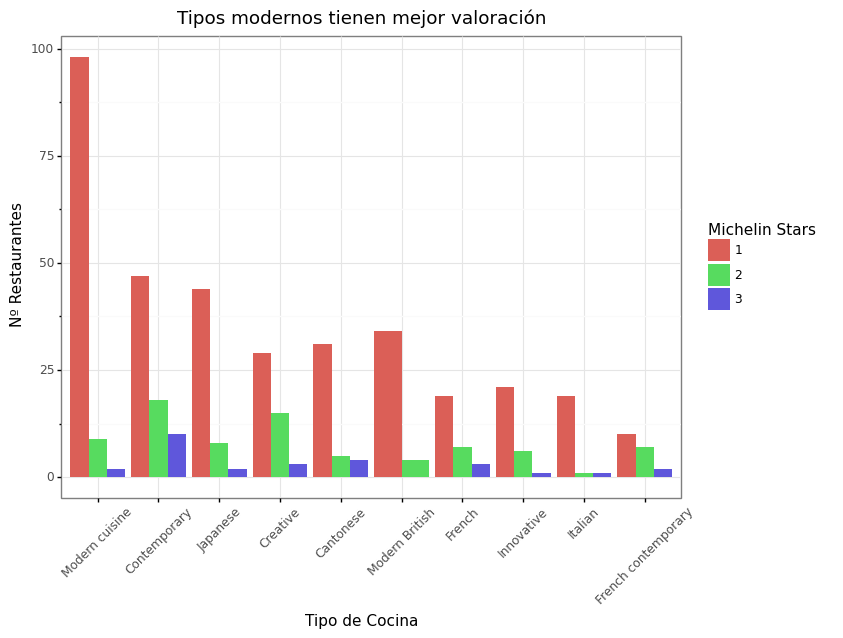

<ggplot: (-9223371886859120824)>

In [29]:
cocina_star = michelin[["cuisine","Michelin Stars"]][michelin.cuisine.isin(cocina.index.tolist())]
ggplot(cocina_star) +\
geom_bar(aes(x = "cuisine",fill="Michelin Stars"), 
             position = "dodge") +\
scale_x_discrete(limits=cocina.index.tolist()) +\
theme_bw() +\
labs(title="Tipos modernos tienen mejor valoración") +\
xlab("Tipo de Cocina") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 45), figure_size=(8,6))

El tipo de cocina con mejor ratio de 3\* es Contemporánea, seguido de Cantonesa. Vemos que una de las que menos restaurantes de 3\* tiene es la italiana, probablemente por ser muy tradicional. Destaca también el alto número de restaurantes de 1\* en Cocina Moderna, probablemente debido a que es el más popular y sólo unos pocos alcanzan la excelencia. Vamos a ver el precio.

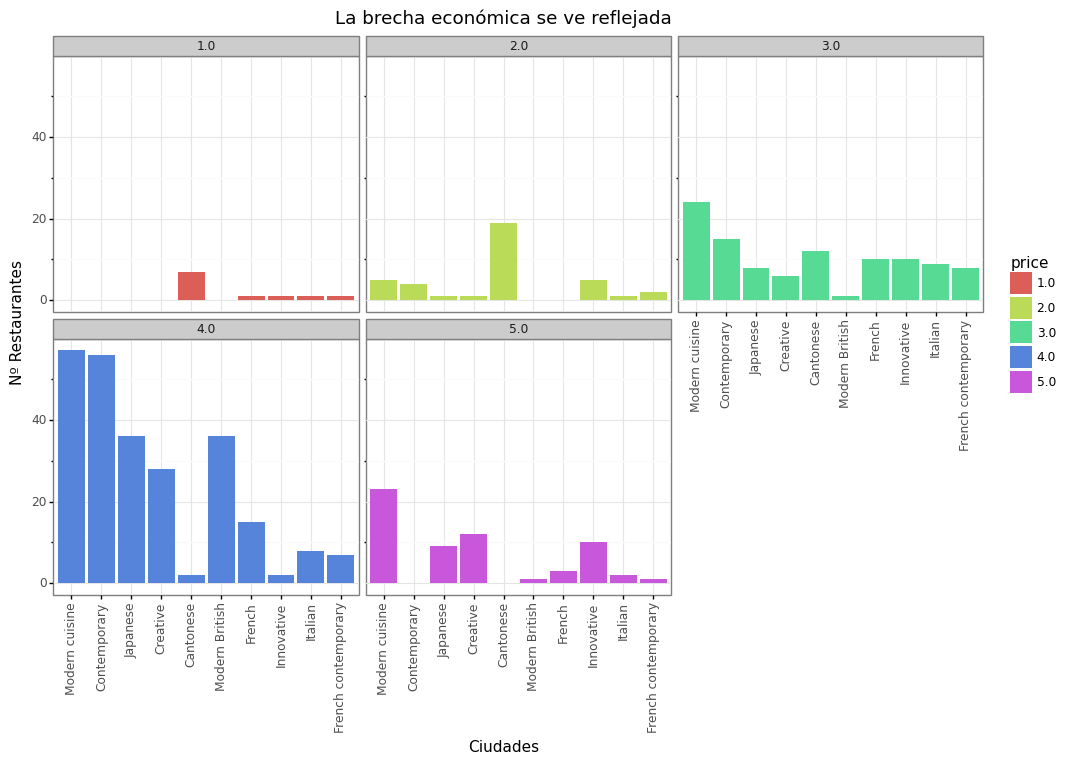

<ggplot: (-9223371886859058656)>

In [30]:
cocina_price = michelin[["cuisine","price"]][michelin.cuisine.isin(cocina.index.tolist())]
ggplot(cocina_price) +\
geom_bar(aes(x = "cuisine",fill="price"), 
             position = "dodge") +\
scale_x_discrete(limits=cocina.index.tolist()) +\
facet_wrap("price") +\
theme_bw() +\
labs(title="La brecha económica se ve reflejada") +\
xlab("Ciudades") +\
ylab("Nº Restaurantes") +\
theme(axis_text_x = element_text(angle = 90), figure_size=(12,7))

Vemos que en los tramos de precios más asequibles, la comida Cantonesa es la que destaca en número. Esto se puede deber a que este tipo de comida se sirve en restaurantes de variante *Street Food* y son más baratos. En el tramo 4 es donde se encuentran la mayoría de restaurantes, con Cocina Moderna y Contemporánea muy igualadas. Vemos aquí también el auge de cocina Moderna Británica. Por último, los restaurantes más caros tienden a tipos de cocina Innovativa, Moderna, Creativa o Japonesa.

### Índices de Calidad de Vida

Como ya he comentado, los índices de calidad de vida se asignan por país, por lo que es probable que haya ineficiencias a la hora de ver la influencia que tiene cada índice en el precio y estrellas de un restaurante en particular. Sin embargo, deduzco que se podrán extraer conclusiones interesantes. Primero vamos a ver el significado de cada variable.

* **Quality of Life Index**. Es un indicador general de calidad de vida. Cuanto más alto mejor.
* **Purchasing Power Index**. Capacidad del país de adquirir bienes y servicios. Cuanto más alto mejor.
* **Safety Index**. Nivel de seguridad de los ciudadanos (bajos crímenes, buena respuesta de policía, ect.). Cuanto más alto mejor.
* **Health Care Index**. Nivel de servicios de salud del país. Cuanto más alto mejor.
* **Cost of Living Index**. Coste de vida del país. Cuanto más alto peor (más caro para el ciudadano).
* **Property Price to Income Ratio**. Ratio de precio de vivienda frente a sueldo. Cuanto más alto peor (más caro para el ciudadano).
* **Traffic Commute Time Index**. Tiempo de viaje de hogar al trabajo. Cuanto más alto peor.
* **Pollution Index**. Nivel de contaminación del país. Cuanto más alto peor.
* **Climate Index**. Indica la posibilidad de que el clima agrade a los ciudadanos. Cuanto más alto mejor.

In [31]:
from plotnine import options

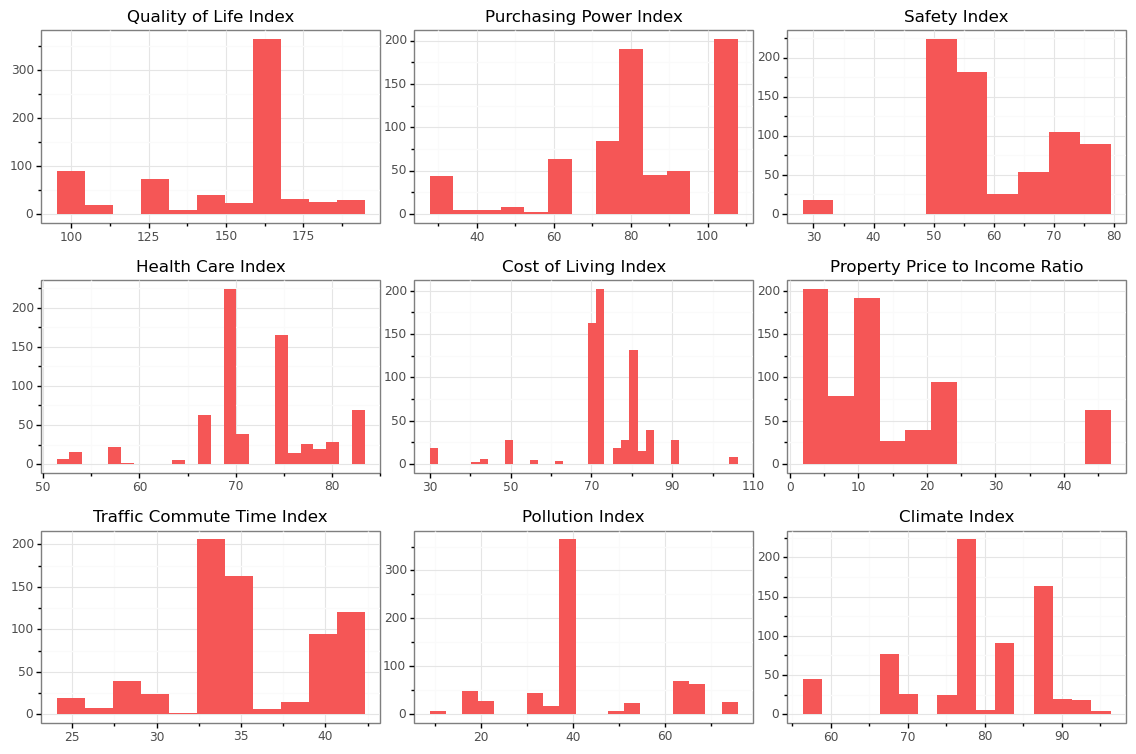

In [32]:
indices = ["Quality of Life Index","Purchasing Power Index","Safety Index","Health Care Index",
           "Cost of Living Index","Property Price to Income Ratio","Traffic Commute Time Index",
           "Pollution Index","Climate Index"]

fig = (ggplot() + geom_blank(data=michelin) + theme_void() + theme(figure_size=(14,9))).draw()
gs = gridspec.GridSpec(3,3,hspace=0.3,wspace=0.1)

idx = 0
for i in range(3):
    for j in range(3):
        p = ggplot(michelin) + geom_histogram(aes(x=indices[idx]), fill='#f55656') +\
            theme_bw()
        ax = fig.add_subplot(gs[i,j])
        ax.set_title(indices[idx])
        _ = p._draw_using_figure(fig, [ax])
        idx += 1

fig.show()

Vemos que todos los índices siguen distribuciones muy distintas y que no se asemejan a distribuciones estadísticas convencionales. Para ver cómo dependen las estrellas y el precio del restaurante se van a calcular sus medias por tramos de cada índice numérico y contínuo.

In [33]:
# para calcular medias pasamos a numérico
michelin["price"] = michelin["price"].astype(float)
michelin["Michelin Stars"] = michelin["Michelin Stars"].astype(float)

In [34]:
# hacemos una función para ahorrar código
def indice_media(idx, titulo):
    g = michelin.groupby(idx, as_index=False)[["price","Michelin Stars"]].mean()

    p = ggplot(g, aes(x=idx)) + geom_line(aes(y="price", color=["price"])) +\
    geom_line(aes(y="Michelin Stars", color=["Michelin Stars"])) +\
    theme_bw() + ylab("") +\
    scale_color_manual(values=["red","blue"], labels=["Precio", "Estrellas Michelin"], name="Leyenda") +\
    labs(title=titulo)
    print(p)

Teniendo ya la función vamos a analizar cada índice. Cabe comentar que es muy probable que no se encuentren relaciones específicas debido a que los índices se dan por país y no por ciudad. Un posible trabajo futuro sería el de encontrar la manera de unir el dataset de restaurantes con el de índices de calidad POR CIUDAD. Dicho esto vamos a ver qué conclusiones se pueden extraer.

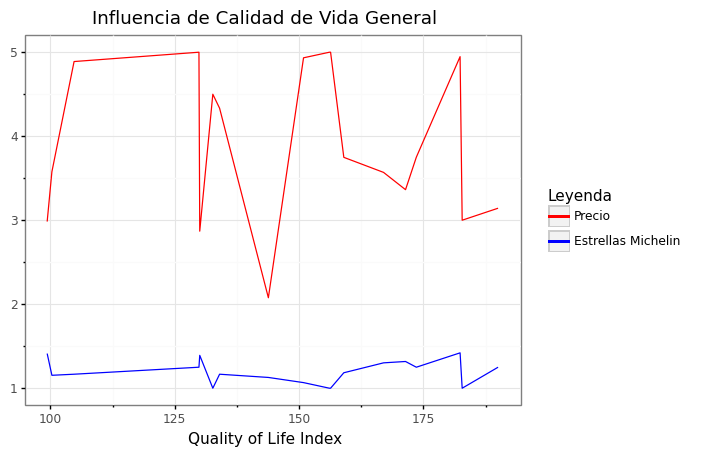

<ggplot: (-9223371886858589560)>


In [35]:
indice_media("Quality of Life Index", "Influencia de Calidad de Vida General")

Viendo la gráfica del índice de calidad de vida general, no parece que haya ninguna relación ni influencia con el precio ni con el número de estrellas Michelin.

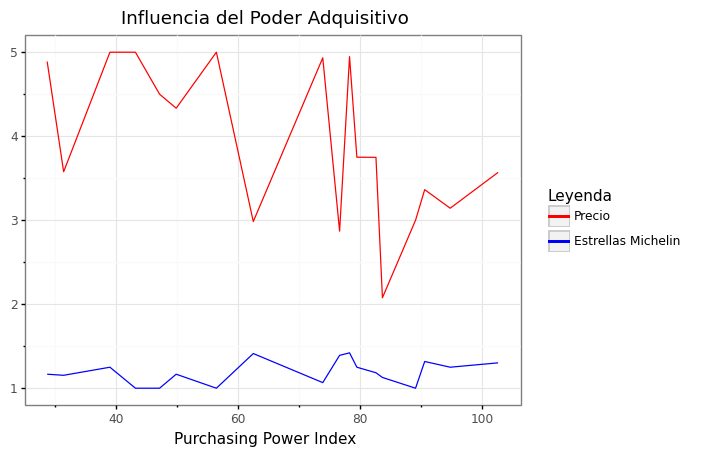

<ggplot: (-9223371886858631412)>


In [36]:
indice_media("Purchasing Power Index", "Influencia del Poder Adquisitivo")

A pesar del ruido en la gráfica se puede observar un ligero descenso del precio en los valores más altos de Poder Adquisitvo. Esto puede estar causado por lo que se ha comentado de países desarrollados vs los nuevos desarrollados. A mayor poder adquisitivo más desarrollado está el pais -> los precios no suben de categoría 4. También puede ser que a mayor poder adquisitivo, mayor es la facilidad de obtener materias primas y de comenzar un negocio, por lo tanto hay más oferta y el precio baja. También se ve que en general, para un poder adquisitivo mayor, la media de estrellas es algo superior.

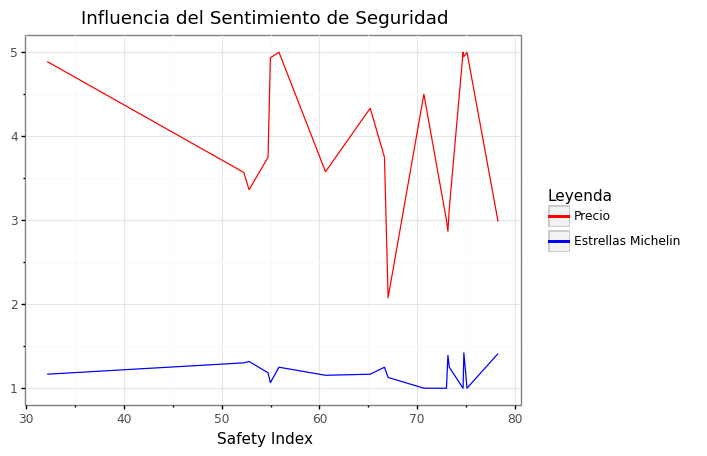

<ggplot: (-9223371886859680584)>


In [37]:
indice_media("Safety Index", "Influencia del Sentimiento de Seguridad")

Hasta un valor de Seguridad ~ 70 se ve una bajada general del precio. Esto puede ser porque a mayor seguridad, no es necesaria una compensación mayor en los precios de los restaurantes. Para valores altos el ruido es muy alto.

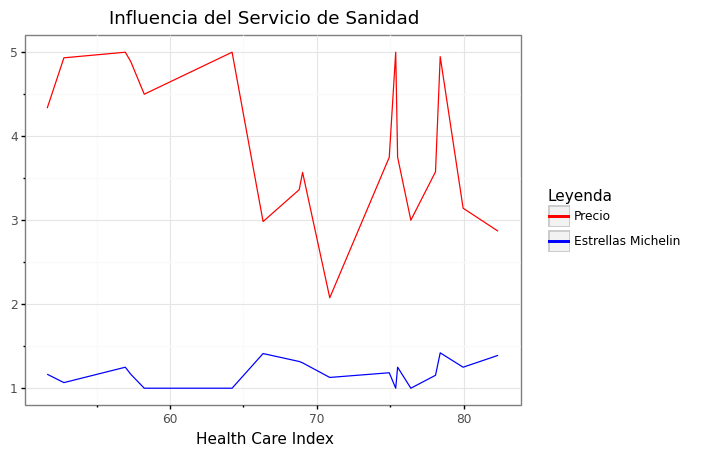

<ggplot: (-9223371886859413952)>


In [38]:
indice_media("Health Care Index", "Influencia del Servicio de Sanidad")

Aquí se ve algo más claro que a medida que aumenta el índice de Sanidad, el precio baja y las estrellas aumentan. El precio puede estar relacionado, de nuevo, a que no se necesita compensar con el precio y que el país esta lo suficientemente desarrollado para tener precios más razonables. El número de estrellas también demuestra el desarrollo del país.

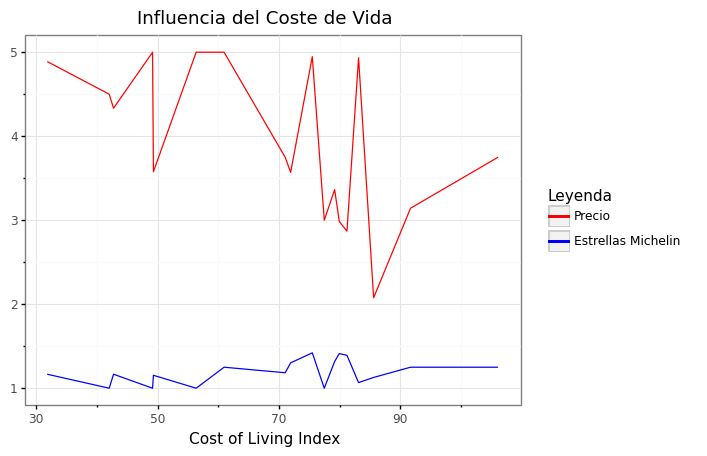

<ggplot: (-9223371886858672268)>


In [39]:
indice_media("Cost of Living Index", "Influencia del Coste de Vida")

Se ve un claro descenso del precio de los restaurantes a medida que aumenta el coste de vida, lo cual va en contra de la lógica. Esto también está relacionado con el desarrollo del país en cuestión, además, puede ser que el coste de vida solo esté relacionado con los gastos comunes como vivienda y comida y no con el precio de restaurantes. Parece ser también que el número de estrellas aumenta ligeramente.

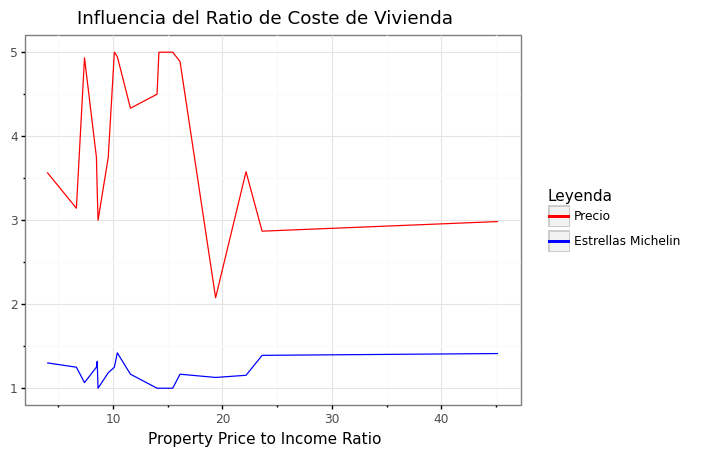

<ggplot: (-9223371886858974448)>


In [40]:
indice_media("Property Price to Income Ratio", "Influencia del Ratio de Coste de Vivienda")

Otro caso parecido al anterior, cuanto más alto es el ratio de coste de la vivienda, el precio es algo menor y el número de estrellas sube ligeramente.

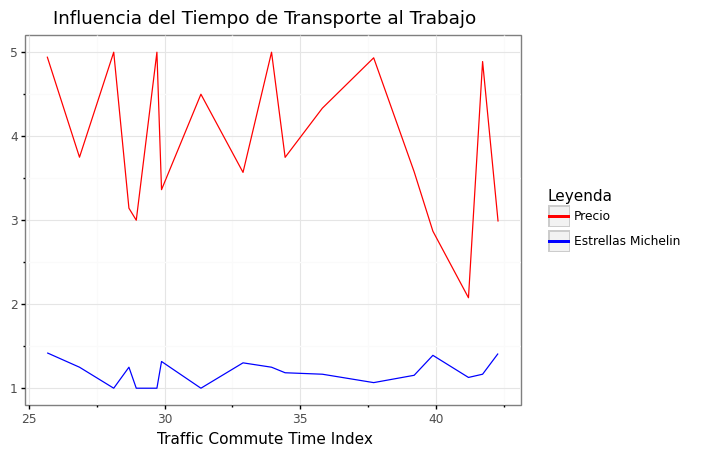

<ggplot: (-9223371886858672360)>


In [41]:
indice_media("Traffic Commute Time Index", "Influencia del Tiempo de Transporte al Trabajo")

En este caso la relación es más difícil de ver, no parece que haya una relación clara.

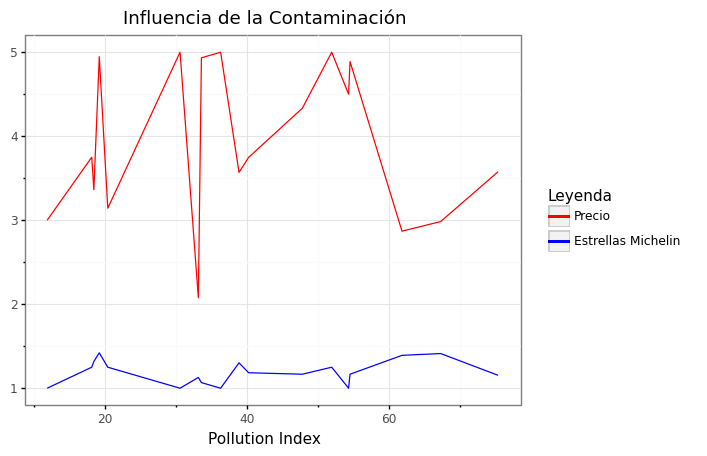

<ggplot: (-9223371886858669704)>


In [42]:
indice_media("Pollution Index", "Influencia de la Contaminación")

Lo mismo del caso anterior, no parece que haya una relación clara.

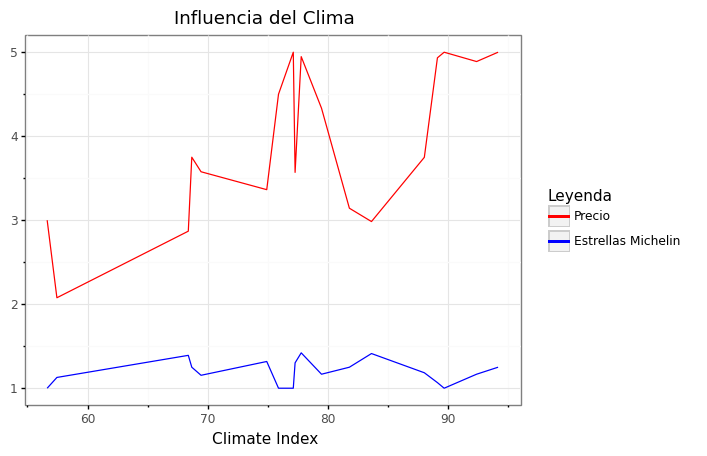

<ggplot: (-9223371886859409280)>


In [43]:
indice_media("Climate Index", "Influencia del Clima")

En el caso de las estrellas no parece que haya relación. En el caso del precio sí se ve claro que a medida que aumenta el índice del Clima el precio también aumenta. Esto puede estar relacionado porque a medida que el clima es más agradable a los ciudadanos, la demanda de restaurantes y de realizar actividades fuera del hogar aumenta al mismo ritmo, también por acción del turismo.

### Relación Precio-Estrellas

Por último, vamos a ver cómo se relacionan las dos variables que hemos considerado como *target*.

In [44]:
np.corrcoef(michelin["Michelin Stars"],michelin["price"])

array([[1.        , 0.20415821],
       [0.20415821, 1.        ]])

El coeficiente de correlación indica que no hay mucha correlación. Esta afirmación es relativa porque ambas variables son categóricas y no hay un gran número de observaciones, por lo tanto, diré que existe una ligera correlación.

## Conclusiones

* En primer lugar, como trabajo futuro, cruzar con datos de calidad de vida por ciudad, las conclusiones serán más precisas y significativas.
* EEUU y UK tienen el mayor número de restaurantes, sin embargo, la distribución de 3\* es muy distinta, que se agrupan en gran medida en Hong Kong.
* Los precios se pueden dividir en países ya desarrollados y los de nuevo desarrollo. Los ya desarrollados (EEUU, UK...) tienen una gama de precios más conservadora, no superando la categoría 4. Sin embargo, los países de nuevo desarrollo (Hong Kong, Corea del Sur...) agrupan muchos de sus restaurantes en la categoría más alta de precios.
* Los tipos de cocina más comunes son los contemporáneos, innovadores y de temática asiática. Los tipos más tradicionales son relegados a puestos más bajos en el top 10. Esta tendencia se repite en los restaurantes de 3\*.
* Los tipos de cocina más caros son Moderna, Innovadora y Japonesa entre otros. Cabe destacar el gran número de restaurantes de comida Cantonesa de 3\*, pero con una gama de precios más baja. Esto puede ser porque este tipo de comida se sirve en establecimientos más modernos de temática *Street Food*.
* Los índices de calidad de vida indican reflejan lo que ya se explicaba de las diferencias entre países desarrollados vs nuevo desarrollo. A mayor poder adquisitivo, sanidad, seguridad, coste de vida, etc. (países ya desarrollados) se ve un decrecimiento en el precio y en ocasiones un auento de la media de estrellas. Al contrario ocurre con el clima, a mejor clima el precio aumenta, probablemente debido a que aumenta la demanda de la ciudadanía y el turismo,
* Por último, existe una ligera correlación positiva entre precio y estrellas, pero no es concluyente. Se necesitará de un estudio más detallado para aclaralo.